In [98]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import math
import random

from torch.autograd import Variable

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [99]:
in_dim, hid1_dim, hid2_dim, out_dim = 4, 8, 9, 3

In [100]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [101]:
EPOCHS = 500
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))
act_func_relu = torch.nn.ReLU()
act_func_cel = torch.nn.CrossEntropyLoss()
loss_func = torch.nn.CrossEntropyLoss()

In [102]:
def get_fitness(X_train, y_train, weights, act_func_relu, act_func_cel, loss_func):
    w1, w2, w3 = [], [], []
    lengths = 0
    for i in range(in_dim) :
        w1.append(weights[lengths : hid1_dim + lengths])
        lengths += hid1_dim
    w1 = np.array(w1)
    
    for i in range(hid1_dim) :
        w2.append(weights[lengths : hid2_dim + lengths])
        lengths += hid2_dim
    w2 = np.array(w2)
    
    for i in range(hid2_dim) :
        w3.append(weights[lengths : out_dim + lengths])
        lengths += out_dim
    w3 = np.array(w3)

    w1, w2, w3 = Variable(torch.from_numpy(w1)).float(), Variable(torch.from_numpy(w2)).float(), Variable(torch.from_numpy(w3)).float()
    
    y_pred = X_train.mm(w1)
    y_pred = act_func_relu(y_pred)
    y_pred = y_pred.mm(w2)
    y_pred = act_func_relu(y_pred)
    y_pred = y_pred.mm(w3)
    loss = loss_func(y_pred, y_train)
    
    return loss.item()

def tester(X_test, y_test, weights, act_func_relu, act_func_cel):
    w1, w2, w3 = [], [], []
    lengths = 0
    for i in range(in_dim) :
        w1.append(weights[lengths : hid1_dim + lengths])
        lengths += hid1_dim
    w1 = np.array(w1)
    
    for i in range(hid1_dim) :
        w2.append(weights[lengths : hid2_dim + lengths])
        lengths += hid2_dim
    w2 = np.array(w2)
    
    for i in range(hid2_dim) :
        w3.append(weights[lengths : out_dim + lengths])
        lengths += out_dim
    w3 = np.array(w3)

    w1, w2, w3 = Variable(torch.from_numpy(w1)).float(), Variable(torch.from_numpy(w2)).float(), Variable(torch.from_numpy(w3)).float()
    
    t_y_pred = X_test.mm(w1)
    t_y_pred = act_func_relu(t_y_pred)
    t_y_pred = t_y_pred.mm(w2)
    t_y_pred = act_func_relu(t_y_pred)
    t_y_pred = t_y_pred.mm(w3)
    
    return t_y_pred

In [103]:
wolf_no = 20
lb, ub, dim = -10, 10, in_dim * hid1_dim + hid1_dim * hid2_dim + hid2_dim * out_dim

alpha_pos = np.zeros(dim)
alpha_score = float("inf")

beta_pos = np.zeros(dim)
beta_score = float("inf")

delta_pos = np.zeros(dim)
delta_score = float("inf")

In [104]:
population = np.zeros((wolf_no, dim))
valid = []
for i in range(dim) :
    population[:, i] = (np.random.uniform(lb, ub, wolf_no))

In [105]:
for iter in range(EPOCHS) :
    for i in range(wolf_no) :
        fitness = get_fitness(X_train, y_train, population[i, :], act_func_relu, act_func_cel, loss_func)
        
        if fitness < alpha_score:
            delta_score = beta_score  # Update delta
            delta_pos = beta_pos.copy()
            beta_score = alpha_score  # Update beta
            beta_pos = alpha_pos.copy()
            alpha_score = fitness  # Update alpha
            alpha_pos = population[i, :].copy()

        if fitness > alpha_score and fitness < beta_score:
            delta_score = beta_score  # Update delte
            delta_pos = beta_pos.copy()
            beta_score = fitness  # Update beta
            beta_pos = population[i, :].copy()

        if fitness > alpha_score and fitness > beta_score and fitness < delta_score:
            delta_score = fitness  # Update delta
            delta_pos = population[i, :].copy()
            
    # a는 선형적으로 감소하는 값으로 2 ~ 0을 가짐
    a = 2 - iter * ((2) / EPOCHS)
    
    for i in range(wolf_no) :
        for j in range(dim) :
            r1 = random.random()  # r1 is a random number in [0,1]
            r2 = random.random()  # r2 is a random number in [0,1]
            A1 = 2 * a * r1 - a  # Equation (3.3)
            C1 = 2 * r2  # Equation (3.4)
            D_alpha = abs(C1 * alpha_pos[j] - population[i, j])  # Equation (3.5)-part 1
            X1 = alpha_pos[j] - A1 * D_alpha  # Equation (3.6)-part 1

            r1 = random.random()
            r2 = random.random()
            A2 = 2 * a * r1 - a  # Equation (3.3)
            C2 = 2 * r2  # Equation (3.4)
            D_beta = abs(C2 * beta_pos[j] - population[i, j])  # Equation (3.5)-part 2
            X2 = beta_pos[j] - A2 * D_beta  # Equation (3.6)-part 2

            r1 = random.random()
            r2 = random.random()
            A3 = 2 * a * r1 - a  # Equation (3.3)
            C3 = 2 * r2  # Equation (3.4)
            D_delta = abs(C3 * delta_pos[j] - population[i, j])  # Equation (3.5)-part 3
            X3 = delta_pos[j] - A3 * D_delta  # Equation (3.5)-part 3

            population[i, j] = (X1 + X2 + X3) / 3  # Equation (3.7)
    
    
    loss_list[iter] = alpha_score
    if iter % 20 == 0:
         print(iter, "loss :", alpha_score, end="")
            
            
    w_set = alpha_pos
    valid = tester(X_test, y_test, w_set, act_func_relu, act_func_cel)
    correct = (torch.argmax(valid, dim=1) == y_test).type(torch.FloatTensor)
    accuracy_list[iter] = correct.mean().item()
    if iter % 20 == 0:
         print(' ', "acc :", correct.mean().item())

0 loss : 222.1186981201172  acc : 0.5
20 loss : 33.708641052246094  acc : 0.800000011920929
40 loss : 4.176002025604248  acc : 0.7666666507720947
60 loss : 1.1346163749694824  acc : 0.7666666507720947
80 loss : 0.6955342888832092  acc : 0.46666666865348816
100 loss : 0.4778292775154114  acc : 0.8333333134651184
120 loss : 0.4051986634731293  acc : 0.8333333134651184
140 loss : 0.4051986634731293  acc : 0.8333333134651184
160 loss : 0.4051986634731293  acc : 0.8333333134651184
180 loss : 0.4051986634731293  acc : 0.8333333134651184
200 loss : 0.3713882565498352  acc : 0.8333333134651184
220 loss : 0.33975252509117126  acc : 0.800000011920929
240 loss : 0.33566582202911377  acc : 0.800000011920929
260 loss : 0.33566582202911377  acc : 0.800000011920929
280 loss : 0.33566582202911377  acc : 0.800000011920929
300 loss : 0.33566582202911377  acc : 0.800000011920929
320 loss : 0.33566582202911377  acc : 0.800000011920929
340 loss : 0.33566582202911377  acc : 0.800000011920929
360 loss : 0.31

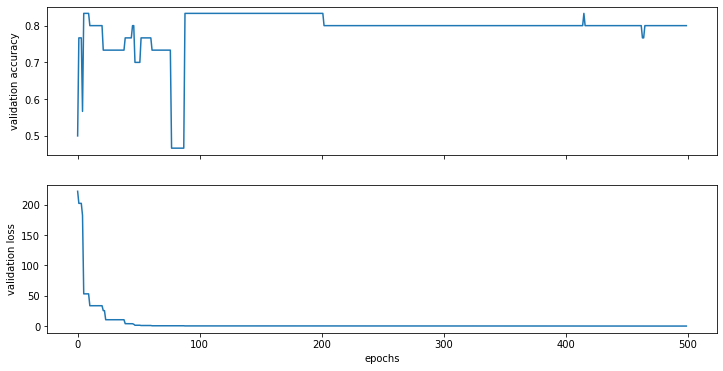

In [106]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");